# Read Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
import operator

from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
import math

from h2o.estimators.deeplearning import H2ODeepLearningEstimator

%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test_V2.csv')

## EDA

In [3]:
train.shape

(1334089, 29)

In [4]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,cbf947ad66eaaa,63052212f1d49d,615ae16e0a4b3f,0,1,300.0,3,0,1,20,...,1,0.0,0,0.0,0,0,332.00,2,1478,0.3846
1,48cba92a123668,830f96b6daa09a,73db6d8ec29694,1,1,382.7,1,0,3,13,...,1,5080.0,0,0.0,0,0,2724.00,7,1408,0.7241
2,6b23deb3a1c0a2,effcfd91eb5152,428c5034353fb4,0,0,0.0,0,0,0,92,...,0,0.0,0,0.0,0,0,29.95,0,1500,0.0417
3,900f7461ca73e2,63f3746bed1687,16ad5a85a2e836,0,1,203.3,2,1,0,15,...,0,0.0,0,0.0,0,0,544.80,5,1510,0.7500
4,f2ce32babea5f5,699d9ca8a02a31,6a3905e0c63077,0,0,100.0,1,1,0,22,...,0,0.0,0,0.0,0,0,89.50,2,0,0.9259


In [5]:
train.dtypes

Id                  object
groupId             object
matchId             object
assists              int64
boosts               int64
damageDealt        float64
DBNOs                int64
headshotKills        int64
heals                int64
killPlace            int64
killPoints           int64
kills                int64
killStreaks          int64
longestKill        float64
matchDuration        int64
matchType           object
maxPlace             int64
numGroups            int64
rankPoints           int64
revives              int64
rideDistance       float64
roadKills            int64
swimDistance       float64
teamKills            int64
vehicleDestroys      int64
walkDistance       float64
weaponsAcquired      int64
winPoints            int64
winPlacePerc       float64
dtype: object

* groupId - Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* matchId - Integer ID to identify match. There are no matches that are in both the training and testing set.
* assists - Number of enemy players this player damaged that were killed by teammates.
* boosts - Number of boost items used.
* damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
* DBNOs - Number of enemy players knocked.
* headshotKills - Number of enemy players killed with headshots.
* heals - Number of healing items used.
* killPlace - Ranking in match of number of enemy players killed.
* killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.)
* kills - Number of enemy players killed.
* killStreaks - Max number of enemy players killed in a short amount of time.
* longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a - player and driving away may lead to a large longestKill stat.
* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* numGroups - Number of groups we have data for in the match.
* revives - Number of times this player revived teammates.
* rideDistance - Total distance traveled in vehicles measured in meters.
* roadKills - Number of kills while in a vehicle.
* swimDistance - Total distance traveled by swimming measured in meters.
* teamKills - Number of times this player killed a teammate.
* vehicleDestroys - Number of vehicles destroyed.
* walkDistance - Total distance traveled on foot measured in meters.
* weaponsAcquired - Number of weapons picked up.
* winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.)
* winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [6]:
# Check missing value
np.any(train.isnull()) # There is no missing value, the dataset looks good

False

In [7]:
train = train.drop(['Id','groupId','matchId'],axis=1) 

In [8]:
feature = [x for x in train.columns if x not in ['Id','groupId','matchId', 'matchType','winPlacePerc']]
feature

['assists',
 'boosts',
 'damageDealt',
 'DBNOs',
 'headshotKills',
 'heals',
 'killPlace',
 'killPoints',
 'kills',
 'killStreaks',
 'longestKill',
 'matchDuration',
 'maxPlace',
 'numGroups',
 'rankPoints',
 'revives',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'teamKills',
 'vehicleDestroys',
 'walkDistance',
 'weaponsAcquired',
 'winPoints']

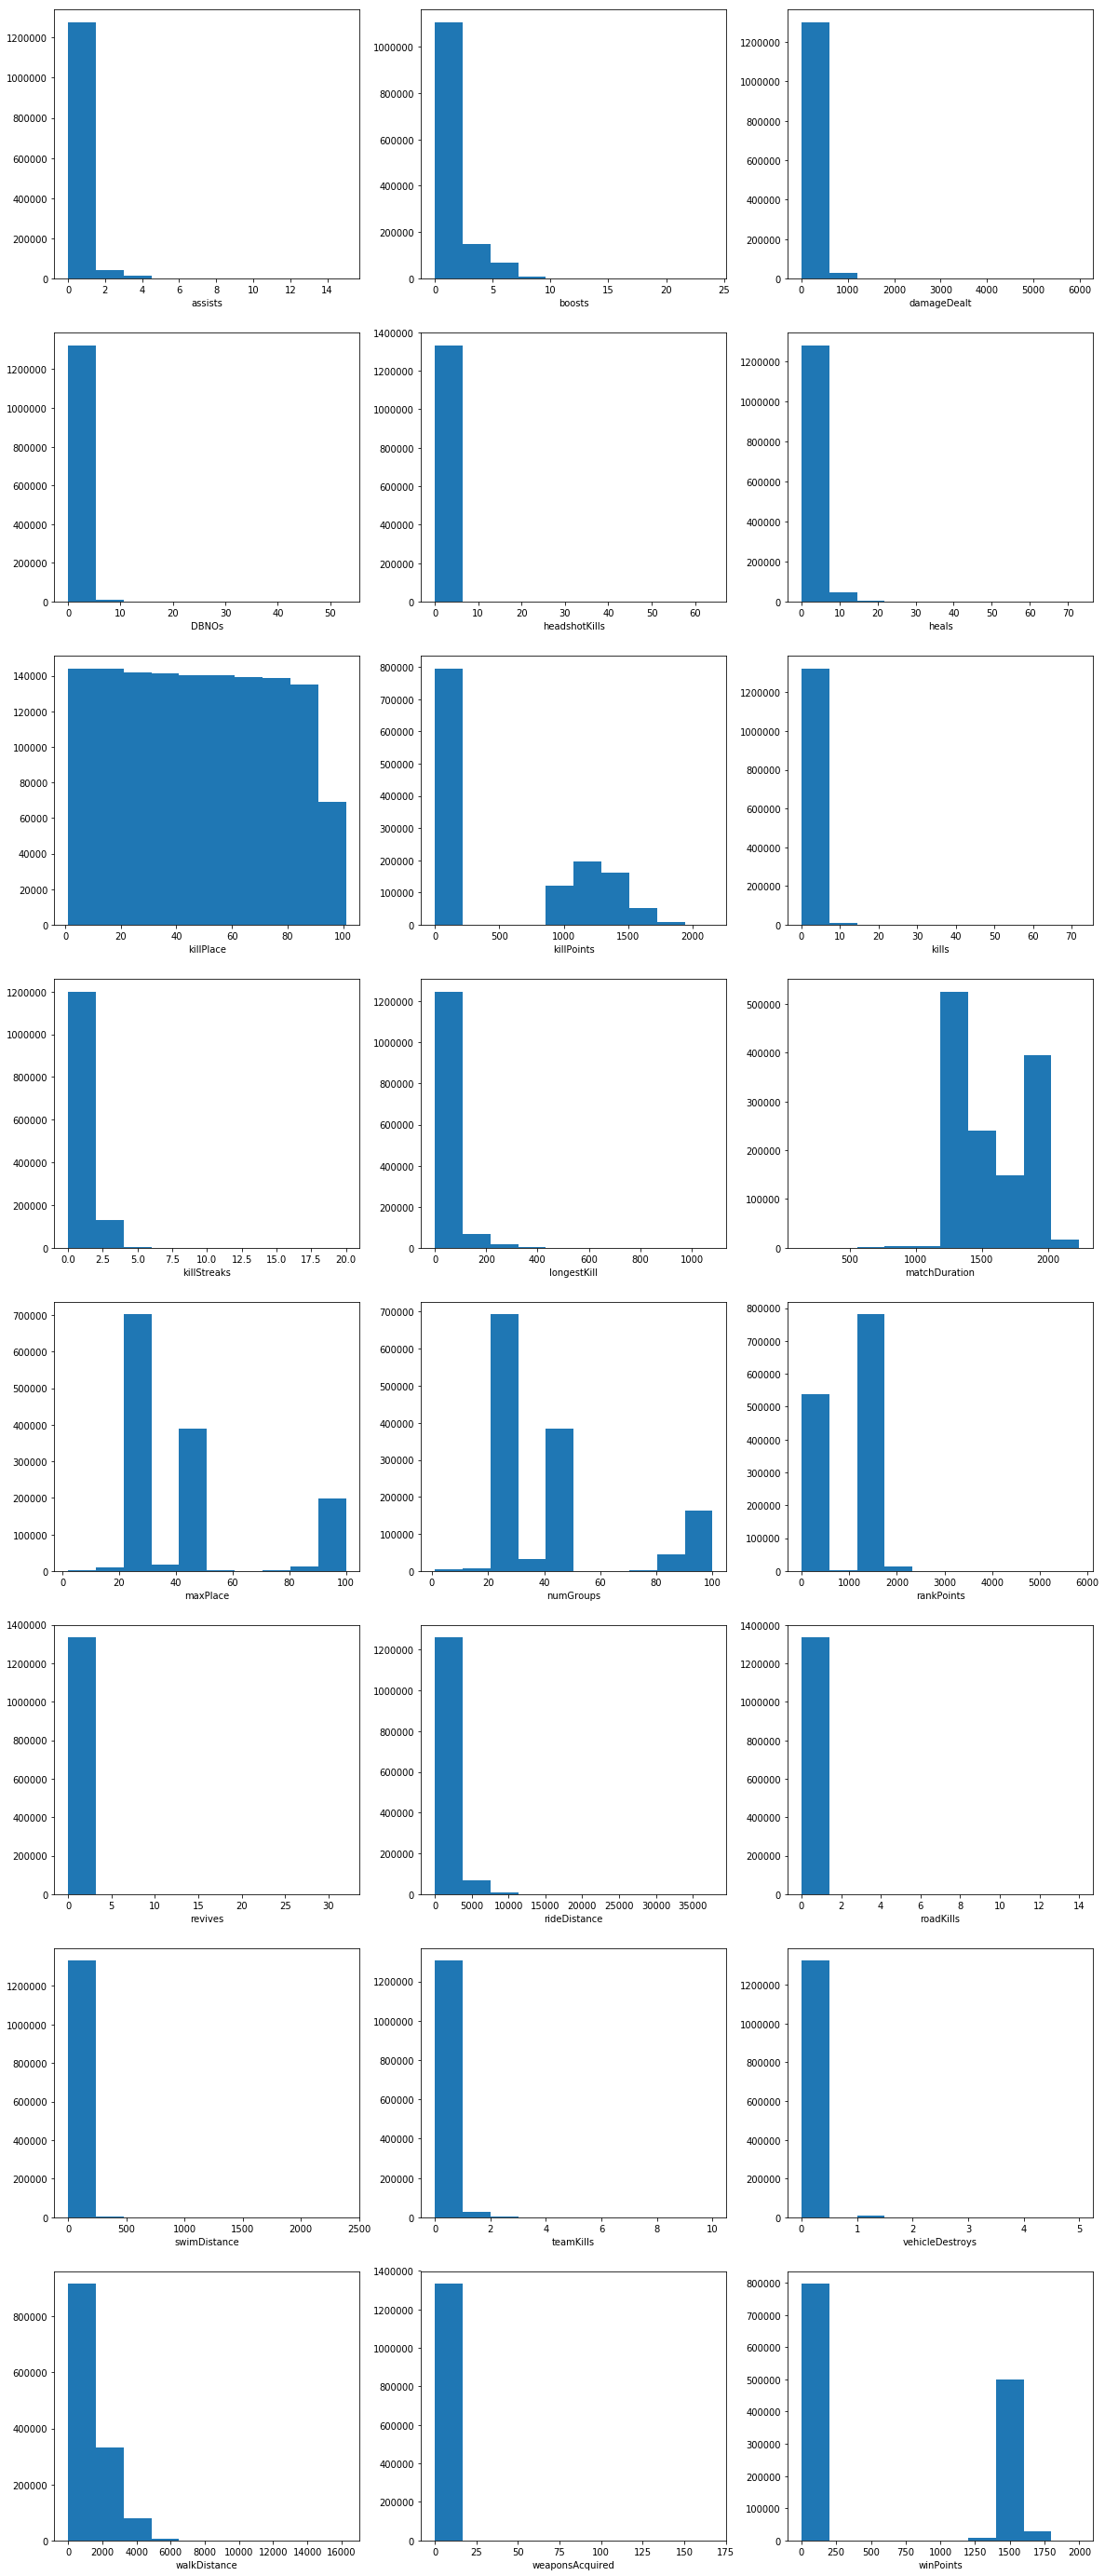

In [9]:
fig = plt.figure(figsize = (20,50))
for i in range(24):
    fig.add_subplot(8,3,i+1)
    plt.hist(train[feature[i]])
    plt.xlabel('{}'.format(feature[i]))

* Create bar plot between the features and target variables

/Users/wangqiang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


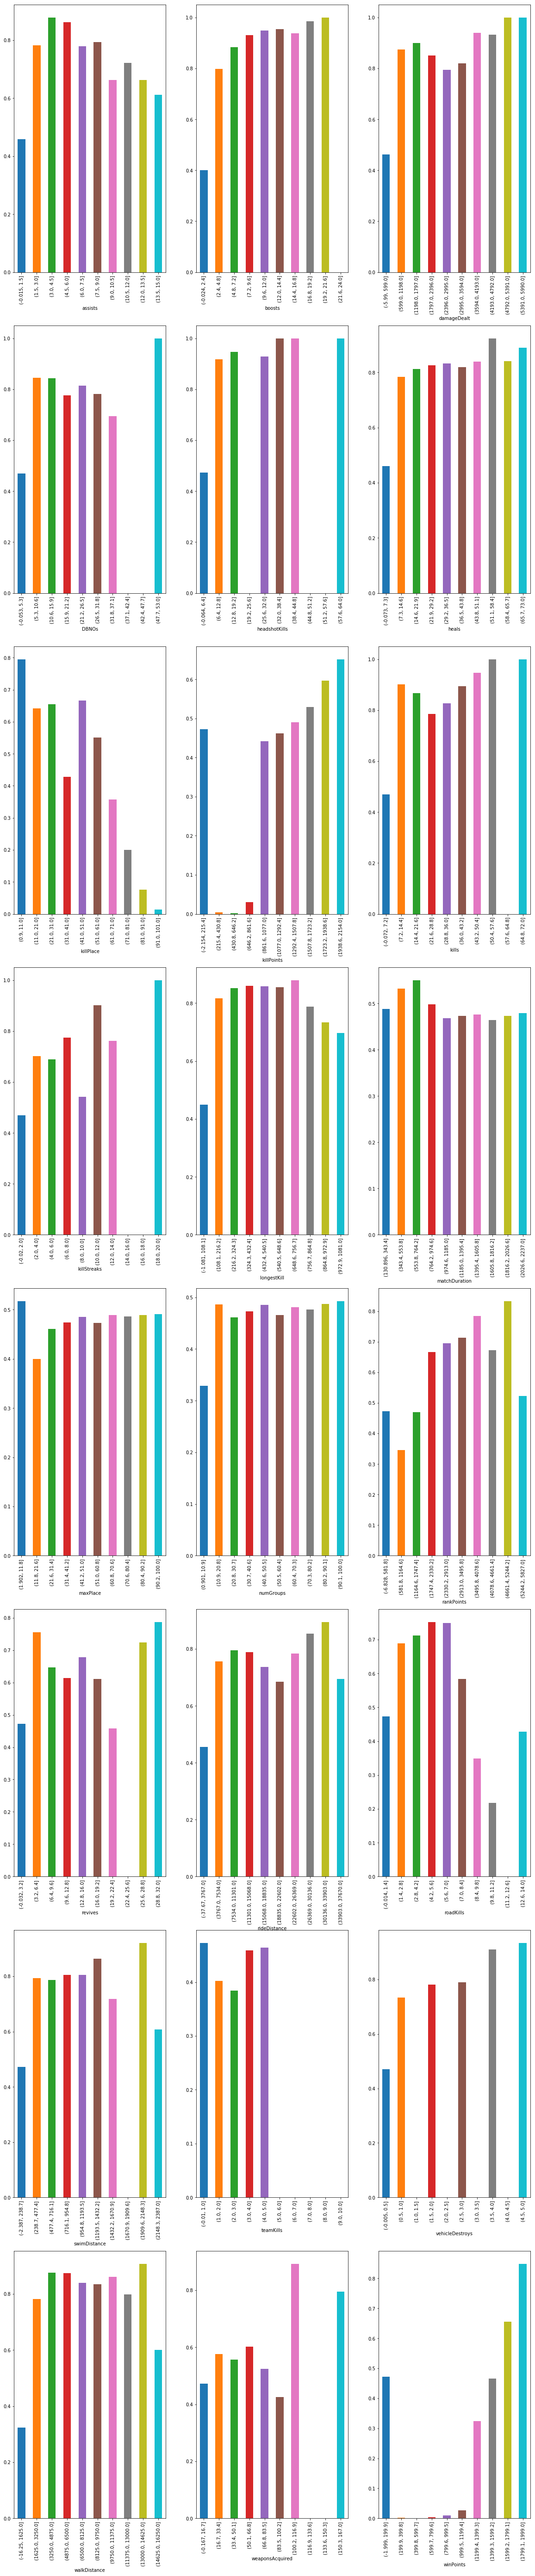

In [10]:
fig = plt.figure(figsize = (20,100))
for i in range(24):
    fig.add_subplot(8,3,i+1)
    df = train[['winPlacePerc',feature[i]]]
    df[feature[i]]=pd.cut(df[feature[i]],10)
    df.groupby(feature[i]).mean()['winPlacePerc'].plot.bar()
    plt.xlabel('{}'.format(feature[i]))

* Distance variables including ride, walk and swim distance are added together.

In [11]:
train['totaldistance'] = train['rideDistance'] +train['walkDistance'] +train['swimDistance']
test['totaldistance'] = test['rideDistance'] + test['walkDistance'] +test['swimDistance']

/Users/wangqiang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


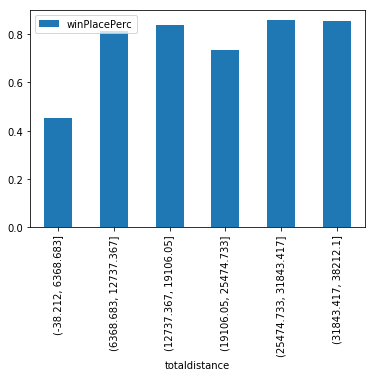

In [12]:
df = train[['winPlacePerc','totaldistance']]
df['totaldistance']=pd.cut(df['totaldistance'],6)
df.groupby('totaldistance').mean().plot.bar()

We added the total distance together, and it shows that  with longer total distance, the higher win place Percentage.

In [13]:
train.drop(['rideDistance','swimDistance','walkDistance'], axis=1, inplace=True)
test.drop(['rideDistance','swimDistance','walkDistance'], axis=1, inplace=True)

* Outliers: Kill players without moving

In [14]:
outliers = train[((train['totaldistance'] == 0) & (train['kills']>0))|((train['totaldistance'] == 0) & (train['headshotKills']>0))]
outlier = [x for x in outliers.index]
train = train.drop(outliers.index)

* Reduce categories in MatchType

In [15]:
train['matchType'].unique()
test['matchType'].unique()

array(['squad-fpp', 'duo-fpp', 'squad', 'solo-fpp', 'solo', 'duo',
       'normal-squad-fpp', 'crashtpp', 'normal-duo-fpp', 'crashfpp',
       'normal-duo', 'flaretpp', 'normal-solo-fpp', 'normal-solo',
       'flarefpp', 'normal-squad'], dtype=object)

There are 3 match types typically, impute this column with the typical match types

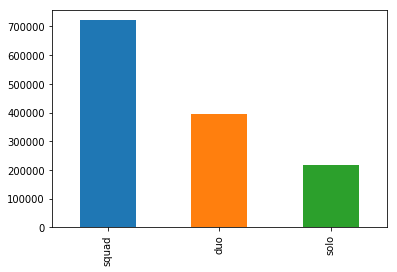

In [16]:
mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
train['matchType'] = train['matchType'].apply(mapper)
test['matchType'] = test['matchType'].apply(mapper)
train['matchType'].unique()
train['matchType'].value_counts().plot.bar()

* Correlation

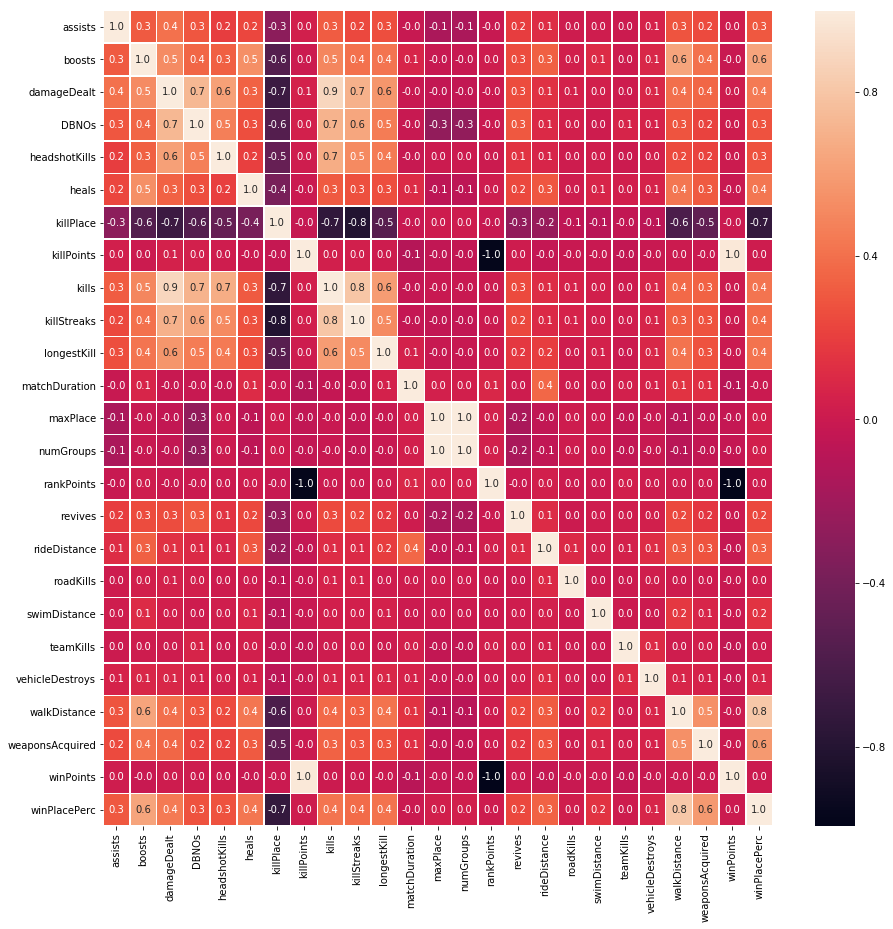

In [9]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

Filter the five most correlated variables

In [17]:
train.corr().nlargest(5,'winPlacePerc')['winPlacePerc']

winPlacePerc       1.000000
totaldistance      0.677854
boosts             0.634854
weaponsAcquired    0.587055
damageDealt        0.441211
Name: winPlacePerc, dtype: float64

# Build Models

In [17]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,5 hours 17 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,3 months and 13 days !!!
H2O cluster name:,H2O_from_python_Carol_bwqlo1
H2O cluster total nodes:,1
H2O cluster free memory:,822 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


## 1. Penalized Logistic Regression

* Encode the target variable to be binomial type

In [18]:
critical_value = [x for x in np.arange(0.5,1,0.1).round(2)]
train_logistic = train
for i in range(len(critical_value)):
    mapper = lambda x: '1' if (x>critical_value[i]) else '0' 
    train_logistic['target{}'.format(i+1)] = train['winPlacePerc'].apply(mapper)
train_logistic.head(5)

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,vehicleDestroys,weaponsAcquired,winPoints,winPlacePerc,totaldistance,target1,target2,target3,target4,target5
0,0,1,300.0,3,0,1,20,1664,2,1,...,0,2,1478,0.3846,332.00,0,0,0,0,0
1,1,1,382.7,1,0,3,13,1233,2,1,...,0,7,1408,0.7241,7804.00,1,1,1,0,0
2,0,0,0.0,0,0,0,92,1000,0,0,...,0,0,1500,0.0417,29.95,0,0,0,0,0
3,0,1,203.3,2,1,0,15,1157,2,2,...,0,5,1510,0.7500,544.80,1,1,1,0,0
4,0,0,100.0,1,1,0,22,0,1,1,...,0,2,0,0.9259,89.50,1,1,1,1,1


In [19]:
col_types = {
    'matchType':'enum'
}

In [20]:
train_h2o= h2o.H2OFrame(train_logistic,column_types=col_types)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [21]:
test_h2o= h2o.H2OFrame(test,column_types = col_types)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [22]:
## Process Independent variables in feature
feature.append('totaldistance')
feature.append('matchType')
len(feature)

26

In [28]:
feature.remove('rideDistance')
feature.remove('swimDistance')
feature.remove('walkDistance')

In [29]:
y = [x for x in train_h2o.columns if 'target' in x]
train_h2o[y] = train_h2o[y].asfactor()

In [30]:
training, validation, testing = train_h2o.split_frame([0.4, 0.3], seed=12345)

In [31]:
for i in range(len(y)):
    model = H2OGeneralizedLinearEstimator(family = 'binomial',
                                            model_id = 'repeater_glm{}'.format(i),
                                            solver = 'IRLSM',
                                            standardize = True,
                                            lambda_search = True,
                                            seed = 12345)
    model.train(feature, y[i], training_frame=training,  validation_frame=validation)
    print(model.model_performance(test_data = validation).auc())

glm Model Build progress: |███████████████████████████████████████████████| 100%
0.9661549790909336
glm Model Build progress: |███████████████████████████████████████████████| 100%
0.9599299923467977
glm Model Build progress: |███████████████████████████████████████████████| 100%
0.9501227825511648
glm Model Build progress: |███████████████████████████████████████████████| 100%
0.9374772340877483
glm Model Build progress: |███████████████████████████████████████████████| 100%
0.9282491016103642


We set initial criteria 0.5,0.6,0.7,0.8,0.9, and build 5 models to select the favorable value, with which the auc of the model is the highest. And the most preferable value is 0.5 when checking in h2o interface.

* Multicollinearity

The coefficients of rankpoints, kill points and winpoints, kills and damagedealt, kills and killplace, number of groups and maxplaces are high, so we delete the kill points, kills and rankpoints,  maxplaces as well as damagedealt, which are all not so important compared to the other one correspondingly. 

In [32]:
feature_regression = feature
feature_regression.remove('killPoints')
feature_regression.remove('rankPoints')
feature_regression.remove('damageDealt')
feature_regression.remove('kills')
feature_regression.remove('maxPlace')
len(feature_regression)

18

In [33]:
model = H2OGeneralizedLinearEstimator(family = 'binomial',
                                            model_id = 'repeater_glm_final',
                                            solver = 'IRLSM',
                                            standardize = True,
                                            lambda_search = True,
                                            seed = 12345)
model.train(feature_regression, y[0], training_frame=training,  validation_frame=validation)
print(model.model_performance(test_data = validation).auc())

glm Model Build progress: |███████████████████████████████████████████████| 100%
0.9655795340583827


* Predict

In [34]:
test2_h2o = test_h2o[feature_regression]
predict = model.predict(test2_h2o)['p1']
predict_pd = predict.as_data_frame()
test_out = pd.concat([test,predict_pd],axis = 1)[['Id','p1']]
test_out = test_out.rename(columns ={'p1':'winPlacePerc'} )
test_out.to_csv('submission_glm.csv',index = False)

glm prediction progress: |████████████████████████████████████████████████| 100%


## 2. Penalized Linear Regression

In [35]:
# assign target and inputs for regression
y = 'winPlacePerc'

In [36]:
# initialize
model = H2OGeneralizedLinearEstimator(family = 'gaussian',
                                            model_id = 'repeater_linear',
                                            solver = 'IRLSM',
                                            standardize = True,
                                            lambda_search = True,
                                            seed = 12345)
# train 
model.train(feature_regression, y, training_frame=training,  validation_frame=validation)
# print trained model info
model.model_performance()

glm Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.018996661249372254
RMSE: 0.13782837606738407
MAE: 0.10266867912753191
RMSLE: NaN
R^2: 0.7988580961561116
Mean Residual Deviance: 0.018996661249372254
Null degrees of freedom: 533797
Residual degrees of freedom: 533779
Null deviance: 50414.05886991144
Residual deviance: 10140.37978159241
AIC: -600811.0211251569


In [37]:
# print non-zero model parameters
for name, val in model.coef().items():
    if val != 0.0:
        print(name, ': ', val)

Intercept :  0.7775941794122444
matchType.solo :  -0.33684673271137505
matchType.squad :  0.1026209793063626
assists :  0.02129631888866089
boosts :  0.026572750566042417
DBNOs :  -0.009522008062861805
headshotKills :  -0.004294019330847645
heals :  0.0002840489601819827
killPlace :  -0.00875478908814133
killStreaks :  -0.18475965153808677
longestKill :  0.0001035504294598274
matchDuration :  -0.00017584653704560827
numGroups :  0.007461159319003519
revives :  0.014840791046607666
roadKills :  -0.050978910439773525
teamKills :  -0.01944298037061483
vehicleDestroys :  -0.013499107408903274
weaponsAcquired :  0.017186674089710106
totaldistance :  4.189399331596485e-05


In [38]:
# measure train, valid and test MSE
print(model.rmse(train=True))
print(model.rmse(valid=True))
print(model.model_performance(test_data=testing).rmse())

0.13782837606738407
0.1378434809803692
0.13833770929535652


* Predict

In [39]:
predict = model.predict(test2_h2o)
predict_pd = predict.as_data_frame()
mapper = lambda x: 0 if (x<0) else x if (0<=x<=1) else 1
predict_pd['predict']=predict_pd['predict'].apply(mapper)
test_out = pd.concat([test['Id'],predict_pd],axis = 1)
test_out = test_out.rename(columns ={'predict':'winPlacePerc'} )
test_out.to_csv('submission_linear.csv',index = False)

glm prediction progress: |████████████████████████████████████████████████| 100%


#### After comparing the grades in Kaggle with above two predicted dataset, we find it's preferable to treat target as the numeric variable with higher Grades in Kaggle, so we set target as numeric type in the following GBM AND MLP Model.

## 2. GBM

In [18]:
# initialize rf model
rf_model = H2ORandomForestEstimator(
    ntrees=200,                      # Up to 500 decision trees in the forest 
    max_depth=20,                    # trees can grow to depth of 30
    stopping_rounds=5,               # stop after validation error does not decrease for 5 iterations/new trees
    score_each_iteration=True,       # score validation error on every iteration/new tree
    model_id='rf_model')             # for easy lookup in flow

# train rf model
rf_model.train(
    x=feature,
    y=y,
    training_frame=training,
    validation_frame=validation)

# print model information
rf_model

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_model


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.007324293767681524
RMSE: 0.08558208789040803
MAE: 0.060603531626088836
RMSLE: 0.05700363283635653
Mean Residual Deviance: 0.007324293767681524

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.007161117801345655
RMSE: 0.08462338802804846
MAE: 0.05988973479399158
RMSLE: 0.05632038913327192
Mean Residual Deviance: 0.007161117801345655
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2019-05-06 19:58:29,0.023 sec,0.0,nan,nan,nan,nan,nan,nan
,2019-05-06 19:58:34,4.747 sec,1.0,0.1119080,0.0766540,0.0125234,0.1129898,0.0771678,0.0127667
,2019-05-06 19:58:38,9.257 sec,2.0,0.1083796,0.0744551,0.0117461,0.0987636,0.0688814,0.0097543
,2019-05-06 19:58:43,13.557 sec,3.0,0.1057531,0.0728865,0.0111837,0.0936833,0.0658769,0.0087766
,2019-05-06 19:58:46,17.319 sec,4.0,0.1038589,0.0717350,0.0107867,0.0912622,0.0643421,0.0083288
---,---,---,---,---,---,---,---,---,---
,2019-05-06 20:02:53,4 min 23.610 sec,44.0,0.0857149,0.0606927,0.0073470,0.0846253,0.0598983,0.0071614
,2019-05-06 20:03:02,4 min 32.951 sec,45.0,0.0856934,0.0606806,0.0073434,0.0846389,0.0599056,0.0071637
,2019-05-06 20:03:12,4 min 42.801 sec,46.0,0.0856457,0.0606496,0.0073352,0.0846334,0.0598981,0.0071628
,2019-05-06 20:03:22,4 min 52.536 sec,47.0,0.0856113,0.0606290,0.0073293,0.0846245,0.0598961,0.0071613



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
walkDistance,778037.6875000,1.0,0.4110640
killPlace,462569.9062500,0.5945341,0.2443916
boosts,260476.9062500,0.3347870,0.1376189
weaponsAcquired,136038.1093750,0.1748477,0.0718736
heals,73810.125,0.0948670,0.0389964
---,---,---,---
revives,1343.6036377,0.0017269,0.0007099
swimDistance,1330.1999512,0.0017097,0.0007028
teamKills,520.4348755,0.0006689,0.0002750
vehicleDestroys,189.6908112,0.0002438,0.0001002



See the whole table with table.as_data_frame()


In [22]:
# measure train, valid and test MSE
print(rf_model.rmse(train=True))
print(rf_model.rmse(valid=True))
print(rf_model.model_performance(test_data=test).rmse())

0.08558208789040803
0.08462338802804846
0.08451456070515279


In [23]:
# GBM with random hyperparameter search
# train many different GBM models with random hyperparameters
# and select best model based on validation error

# define random grid search parameters
hyper_parameters = {'ntrees':list(range(0, 200, 50)),
                    'max_depth':list(range(0, 20, 2)),
                    'sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate':[s/float(10) for s in range(1, 11)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':100,
                   'max_runtime_secs':3600,
                   'seed' : 12345}

# initialize grid search
gsearch = H2OGridSearch(H2OGradientBoostingEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
gsearch.train(x=feature,
              y=y,
              training_frame=training,
              validation_frame=validation)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
Errors/Warnings building gridsearch model

Hyper-parameter: col_sample_rate, 0.4
Hyper-parameter: max_depth, 0
Hyper-parameter: ntrees, 50
Hyper-parameter: sample_rate, 0.4
failure_details: Illegal argument(s) for GBM model: Grid_GBM_py_3_sid_9aa3_model_python_1557187029253_1_model_3.  Details: ERRR on field: _max_depth: _max_depth must be > 0.

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: Grid_GBM_py_3_sid_9aa3_model_python_1557187029253_1_model_3.  Details: ERRR on field: _max_depth: _max_depth must be > 0.

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.gbm.GBM.init(GBM.java:87)
	at hex.tree.SharedTree$Driver.computeImpl(SharedTree.java:207)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:218)
	at hex.ModelBuilder.trainModelNested(ModelB


Hyper-parameter: col_sample_rate, 0.3
Hyper-parameter: max_depth, 0
Hyper-parameter: ntrees, 50
Hyper-parameter: sample_rate, 0.6
failure_details: Illegal argument(s) for GBM model: Grid_GBM_py_3_sid_9aa3_model_python_1557187029253_1_model_64.  Details: ERRR on field: _max_depth: _max_depth must be > 0.

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: Grid_GBM_py_3_sid_9aa3_model_python_1557187029253_1_model_64.  Details: ERRR on field: _max_depth: _max_depth must be > 0.

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.gbm.GBM.init(GBM.java:87)
	at hex.tree.SharedTree$Driver.computeImpl(SharedTree.java:207)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:218)
	at hex.ModelBuilder.trainModelNested(ModelBuilder.java:343)
	at hex.ModelBuilder$TrainModelNestedRunnable.run(ModelBuilder.java:378)
	at water.H2O.runOnH2ONode(H2O.

In [24]:
print(gsearch)

      col_sample_rate max_depth ntrees sample_rate  \
0                 0.9        12    150         0.9   
1                 0.8        12    150         0.7   
2                 0.3        12    150         0.7   
3                 0.5        12    100         0.4   
4                 0.9         8    150         0.2   
5                 1.0        14     50         0.7   
6                 0.3        16    100         0.8   
7                 0.8        12    100         0.2   
8                 0.2        10    150         0.9   
9                 0.8        16    150         0.6   
10                0.9        16    150         1.0   
11                0.6        16    150         0.5   
12                0.5        12     50         0.5   
13                0.6        16    100         0.4   
14                0.9        16     50         0.7   
15                0.4        18    150         1.0   
16                0.4        18    100         0.5   
17                0.5       

[91 rows x 7 columns]



In [25]:
## sort the grid models by increasing RMSE
sorted_grid = gsearch.get_grid(sort_by='rmse',decreasing=False)
print(sorted_grid)

      col_sample_rate max_depth ntrees sample_rate  \
0                 0.9        12    150         0.9   
1                 0.8        12    150         0.7   
2                 0.3        12    150         0.7   
3                 0.5        12    100         0.4   
4                 0.9         8    150         0.2   
5                 1.0        14     50         0.7   
6                 0.3        16    100         0.8   
7                 0.8        12    100         0.2   
8                 0.2        10    150         0.9   
9                 0.8        16    150         0.6   
10                0.9        16    150         1.0   
11                0.6        16    150         0.5   
12                0.5        12     50         0.5   
13                0.6        16    100         0.4   
14                0.9        16     50         0.7   
15                0.4        18    150         1.0   
16                0.4        18    100         0.5   
17                0.5       

[91 rows x 7 columns]



If we sort the grid model by increasing Rmse, then we can select five of models with least Rmse to determine the range of our parameters and apply them to our next model:
* As for col_sample_rate, it ranges from 0.3 to 0.9
* As for max_depth, it ranges from 8 to 12
* As for number of trees, it ranges from 100 to 150
* As for sample_rate, it ranges from 0.2 to 0.9

In [26]:
max_depths = sorted_grid.sorted_metric_table()['max_depth'][0:5]
new_max = int(max(max_depths, key=int))
new_min = int(min(max_depths, key=int))

print ("MaxDepth", new_max)
print ("MinDepth", new_min)

MaxDepth 12
MinDepth 8


In [27]:
# create hyperameter and search criteria lists (ranges are inclusive..exclusive))
hyper_params_tune = {'max_depth' : list(range(new_min,new_max+1,1)),
                'sample_rate': [x/100. for x in range(40,90)],
                'col_sample_rate' : [x/100. for x in range(20,100)]}
search_criteria_tune = {'strategy': "RandomDiscrete",
                   'max_runtime_secs': 3600,  ## limit the runtime to 60 minutes
                   'max_models': 100,  ## build no more than 100 models
                   'seed' : 12345,
                   'stopping_rounds' : 5,
                   'stopping_metric' : "rmse",
                   'stopping_tolerance': 1e-3
                   }

In [28]:
gbm_final_grid = H2OGradientBoostingEstimator(distribution='gaussian',
                    ## more trees is better if the learning rate is small enough 
                    ## here, use "more than enough" trees - we have early stopping
                    ntrees=100,
                    score_tree_interval = 10,
                    ## fix a random number generator seed for reproducibility
                    seed = 12345,
                    ## early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    #5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "rmse",
                    stopping_tolerance = 1e-4)
            
#Build grid search with previously made GBM and hyper parameters
final_grid = H2OGridSearch(gbm_final_grid, hyper_params = hyper_params_tune,
                                    grid_id = 'final_grid',
                                    search_criteria = search_criteria_tune)

In [29]:
#Train grid search
final_grid.train(feature, 
           y,
           max_runtime_secs = 3600, 
           training_frame = training,
           validation_frame = validation)

print(final_grid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
Errors/Warnings building gridsearch model

Hyper-parameter: col_sample_rate, 0.5
Hyper-parameter: max_depth, 11
Hyper-parameter: sample_rate, 0.43
failure_details: Illegal argument(s) for GBM model: final_grid_model_32.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (19.8 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: final_grid_model_32.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (19.8 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.SharedTree.doScoringAndSaveModel(SharedTree.


Hyper-parameter: col_sample_rate, 0.45
Hyper-parameter: max_depth, 9
Hyper-parameter: sample_rate, 0.83
failure_details: Illegal argument(s) for GBM model: final_grid_model_37.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (6.0 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: final_grid_model_37.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (6.0 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.SharedTree.doScoringAndSaveModel(SharedTree.java:683)
	at hex.tree.SharedTree$Driver.scoreAndBuildTrees(SharedTree.java:433)
	at hex.tree.SharedTree$Driver.computeImpl(S


Hyper-parameter: col_sample_rate, 0.27
Hyper-parameter: max_depth, 12
Hyper-parameter: sample_rate, 0.48
failure_details: Illegal argument(s) for GBM model: final_grid_model_42.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (29.0 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: final_grid_model_42.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (29.0 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.SharedTree.doScoringAndSaveModel(SharedTree.java:683)
	at hex.tree.SharedTree$Driver.scoreAndBuildTrees(SharedTree.java:433)
	at hex.tree.SharedTree$Driver.computeImp


Hyper-parameter: col_sample_rate, 0.2
Hyper-parameter: max_depth, 10
Hyper-parameter: sample_rate, 0.64
failure_details: Illegal argument(s) for GBM model: final_grid_model_47.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (9.9 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: final_grid_model_47.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (9.9 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.SharedTree.doScoringAndSaveModel(SharedTree.java:683)
	at hex.tree.SharedTree$Driver.scoreAndBuildTrees(SharedTree.java:433)
	at hex.tree.SharedTree$Driver.computeImpl(S


Hyper-parameter: col_sample_rate, 0.6
Hyper-parameter: max_depth, 8
Hyper-parameter: sample_rate, 0.64
failure_details: Illegal argument(s) for GBM model: final_grid_model_52.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (3.1 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: final_grid_model_52.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (3.1 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.SharedTree.doScoringAndSaveModel(SharedTree.java:683)
	at hex.tree.SharedTree$Driver.scoreAndBuildTrees(SharedTree.java:433)
	at hex.tree.SharedTree$Driver.computeImpl(Sh


Hyper-parameter: col_sample_rate, 0.86
Hyper-parameter: max_depth, 9
Hyper-parameter: sample_rate, 0.74
failure_details: Illegal argument(s) for GBM model: final_grid_model_57.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (6.2 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: final_grid_model_57.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (6.2 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.SharedTree.doScoringAndSaveModel(SharedTree.java:683)
	at hex.tree.SharedTree$Driver.scoreAndBuildTrees(SharedTree.java:433)
	at hex.tree.SharedTree$Driver.computeImpl(S


Hyper-parameter: col_sample_rate, 0.28
Hyper-parameter: max_depth, 8
Hyper-parameter: sample_rate, 0.63
failure_details: Illegal argument(s) for GBM model: final_grid_model_62.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (3.0 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: final_grid_model_62.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (3.0 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.SharedTree.doScoringAndSaveModel(SharedTree.java:683)
	at hex.tree.SharedTree$Driver.scoreAndBuildTrees(SharedTree.java:433)
	at hex.tree.SharedTree$Driver.computeImpl(S


Hyper-parameter: col_sample_rate, 0.51
Hyper-parameter: max_depth, 12
Hyper-parameter: sample_rate, 0.65
failure_details: Illegal argument(s) for GBM model: final_grid_model_67.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (36.2 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: final_grid_model_67.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (36.2 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.SharedTree.doScoringAndSaveModel(SharedTree.java:683)
	at hex.tree.SharedTree$Driver.scoreAndBuildTrees(SharedTree.java:433)
	at hex.tree.SharedTree$Driver.computeImp


Hyper-parameter: col_sample_rate, 0.28
Hyper-parameter: max_depth, 10
Hyper-parameter: sample_rate, 0.88
failure_details: Illegal argument(s) for GBM model: final_grid_model_72.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (10.8 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: final_grid_model_72.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (10.8 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.SharedTree.doScoringAndSaveModel(SharedTree.java:683)
	at hex.tree.SharedTree$Driver.scoreAndBuildTrees(SharedTree.java:433)
	at hex.tree.SharedTree$Driver.computeImp


Hyper-parameter: col_sample_rate, 0.44
Hyper-parameter: max_depth, 9
Hyper-parameter: sample_rate, 0.58
failure_details: Illegal argument(s) for GBM model: final_grid_model_77.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (5.9 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: final_grid_model_77.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (5.9 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.SharedTree.doScoringAndSaveModel(SharedTree.java:683)
	at hex.tree.SharedTree$Driver.scoreAndBuildTrees(SharedTree.java:433)
	at hex.tree.SharedTree$Driver.computeImpl(S


Hyper-parameter: col_sample_rate, 0.96
Hyper-parameter: max_depth, 10
Hyper-parameter: sample_rate, 0.6
failure_details: Illegal argument(s) for GBM model: final_grid_model_82.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (11.7 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: final_grid_model_82.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (11.7 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.SharedTree.doScoringAndSaveModel(SharedTree.java:683)
	at hex.tree.SharedTree$Driver.scoreAndBuildTrees(SharedTree.java:433)
	at hex.tree.SharedTree$Driver.computeImpl


Hyper-parameter: col_sample_rate, 0.86
Hyper-parameter: max_depth, 11
Hyper-parameter: sample_rate, 0.6
failure_details: Illegal argument(s) for GBM model: final_grid_model_87.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (21.5 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: final_grid_model_87.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (21.5 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.SharedTree.doScoringAndSaveModel(SharedTree.java:683)
	at hex.tree.SharedTree$Driver.scoreAndBuildTrees(SharedTree.java:433)
	at hex.tree.SharedTree$Driver.computeImpl


Hyper-parameter: col_sample_rate, 0.51
Hyper-parameter: max_depth, 9
Hyper-parameter: sample_rate, 0.88
failure_details: Illegal argument(s) for GBM model: final_grid_model_92.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (6.1 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: final_grid_model_92.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (6.1 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.SharedTree.doScoringAndSaveModel(SharedTree.java:683)
	at hex.tree.SharedTree$Driver.scoreAndBuildTrees(SharedTree.java:433)
	at hex.tree.SharedTree$Driver.computeImpl(S


Hyper-parameter: col_sample_rate, 0.88
Hyper-parameter: max_depth, 11
Hyper-parameter: sample_rate, 0.67
failure_details: Illegal argument(s) for GBM model: final_grid_model_97.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (21.6 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: final_grid_model_97.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (21.6 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.SharedTree.doScoringAndSaveModel(SharedTree.java:683)
	at hex.tree.SharedTree$Driver.scoreAndBuildTrees(SharedTree.java:433)
	at hex.tree.SharedTree$Driver.computeImp

30  0.0068456758424831924  



In [30]:
sorted_final_grid = final_grid.get_grid(sort_by='rmse',decreasing=False)
print(sorted_final_grid)

     col_sample_rate max_depth sample_rate            model_ids  \
0               0.67        12        0.77  final_grid_model_15   
1               0.54        11        0.78  final_grid_model_19   
2                0.8        11        0.86  final_grid_model_26   
3               0.73        12        0.85  final_grid_model_16   
4               0.92        10        0.63  final_grid_model_12   
5               0.69        12        0.69   final_grid_model_3   
6               0.99        11        0.61  final_grid_model_13   
7               0.88        12        0.75  final_grid_model_10   
8               0.99        11        0.59  final_grid_model_24   
9                0.5        10        0.88  final_grid_model_11   
10              0.68        11        0.46   final_grid_model_1   
11              0.88        11        0.47  final_grid_model_17   
12              0.36        12        0.72   final_grid_model_2   
13              0.43        10        0.85   final_grid_model_

In [31]:
#Get the best model from the list (the model name listed at the top of the table)
best_model = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])
performance_best_model = best_model.model_performance(testing)
print (performance_best_model.rmse())

0.08059192748197039


* Predict

In [40]:
test2_h2o = test_h2o[feature]
predict = best_model.predict(test2_h2o)
predict_pd = predict.as_data_frame()
mapper = lambda x: 0 if (x<0) else x if (0<=x<=1) else 1
predict_pd['predict']=predict_pd['predict'].apply(mapper)
test_out = pd.concat([test['Id'],predict_pd],axis = 1)
test_out = test_out.rename(columns ={'predict':'winPlacePerc'} )
test_out.to_csv('submission_gbm.csv',index = False)

glm prediction progress: |████████████████████████████████████████████████| 100%


## 3. MLP

In [44]:
# neural network

# initialize nn model
nn_model = H2ODeepLearningEstimator(
    epochs=50,                    # read over the data 50 times, but in mini-batches
    hidden=[100],                 # 100 hidden units in 1 hidden layer
    input_dropout_ratio=0.2,      # randomly drop 20% of inputs for each iteration, helps w/ generalization
    hidden_dropout_ratios=[0.05], # randomly set 5% of hidden weights to 0 each iteration, helps w/ generalization
    activation='TanhWithDropout', # bounded activation function that allows for dropout, tanh
    l1=0.001,                     # L1 penalty can help generalization   
    l2=0.01,                      # L2 penalty can increase stability in presence of highly correlated inputs
    adaptive_rate=True,           # adjust magnitude of weight updates automatically (+stability, +accuracy)
    stopping_rounds=5,            # stop after validation error does not decrease for 5 iterations
    score_each_iteration=True,    # score validation error on every iteration
    model_id='nn_model')          # for easy lookup in flow

# train nn model
nn_model.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid)

# print model information
nn_model



deeplearning Model Build progress: |██████████████████████████████████████| 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  nn_model


ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.016555506939401856
RMSE: 0.12866820485031202
MAE: 0.09296825456827437
RMSLE: 0.08893943212628491
Mean Residual Deviance: 0.016555506939401856

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.016919841382500894
RMSE: 0.13007629062400608
MAE: 0.09367992003879294
RMSLE: 0.08978631994400003
Mean Residual Deviance: 0.016919841382500894
Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
,2019-05-06 21:41:39,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan
,2019-05-06 21:41:42,10.236 sec,37306 obs/sec,0.1879388,1,100355.0,0.1304452,0.0170159,0.0949623,0.8216962,0.1320595,0.0174397,0.0957051,0.8153840
,2019-05-06 21:41:49,16.019 sec,40986 obs/sec,0.3760368,2,200795.0,0.1324566,0.0175447,0.0964656,0.8161551,0.1337972,0.0179017,0.0971552,0.8104934
,2019-05-06 21:41:55,21.935 sec,41669 obs/sec,0.5631872,3,300729.0,0.1333948,0.0177942,0.0964853,0.8135415,0.1351320,0.0182607,0.0974311,0.8066935
,2019-05-06 21:42:01,28.263 sec,40893 obs/sec,0.7496615,4,400302.0,0.1335381,0.0178324,0.0956242,0.8131406,0.1350295,0.0182330,0.0964692,0.8069866
,2019-05-06 21:42:07,33.976 sec,41650 obs/sec,0.9372613,5,500476.0,0.1343682,0.0180548,0.0969788,0.8108101,0.1359677,0.0184872,0.0979621,0.8042951
,2019-05-06 21:42:13,39.694 sec,42083 obs/sec,1.1254155,6,600946.0,0.1326298,0.0175907,0.0960249,0.8156740,0.1342425,0.0180210,0.0970201,0.8092300
,2019-05-06 21:42:18,45.490 sec,42673 obs/sec,1.3127138,7,700959.0,0.1292195,0.0166977,0.0938728,0.8250313,0.1308822,0.0171302,0.0947198,0.8186610
,2019-05-06 21:42:24,51.073 sec,43210 obs/sec,1.5005534,8,801261.0,0.1337324,0.0178844,0.0967132,0.8125964,0.1353884,0.0183300,0.0977525,0.8059592
,2019-05-06 21:42:30,56.757 sec,43618 obs/sec,1.6887113,9,901733.0,0.1304181,0.0170089,0.0950459,0.8217701,0.1319592,0.0174132,0.0958990,0.8156644


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
matchType.normal-squad-fpp,1.0,1.0,0.1375032
walkDistance,0.7834584,0.7834584,0.1077280
matchType.normal-duo-fpp,0.6421820,0.6421820,0.0883021
killPlace,0.5023900,0.5023900,0.0690802
weaponsAcquired,0.3588062,0.3588062,0.0493370
---,---,---,---
rankPoints,0.0186444,0.0186444,0.0025637
vehicleDestroys,0.0071515,0.0071515,0.0009833
headshotKills,0.0051309,0.0051309,0.0007055
roadKills,0.0005164,0.0005164,0.0000710



See the whole table with table.as_data_frame()


In [45]:
# measure train, valid and test MSE
print(nn_model.rmse(train=True))
print(nn_model.rmse(valid=True))
print(nn_model.model_performance(test_data=test).rmse())

0.12866820485031202
0.13007629062400608
0.1299096140128062


In [46]:
# NN with random hyperparameter search
# train many different NN models with random hyperparameters
# and select best model based on validation error

# define random grid search parameters
hyper_parameters = {'hidden':[[170, 320], [80, 190], [320, 160, 80], [100], [50, 50, 50, 50]],
                    'l1':[s/1e4 for s in range(0, 1000, 100)],
                    'l2':[s/1e5 for s in range(0, 1000, 100)],
                    'input_dropout_ratio':[s/1e2 for s in range(0, 20, 2)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':20,
                   'max_runtime_secs':600}

# initialize grid search
gsearch = H2OGridSearch(H2ODeepLearningEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
gsearch.train(x=X,
              y=y,
              training_frame=train,
              validation_frame=valid)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%


In [47]:
# show grid search results
gsearch.show()

# select best model
nn_model2 = gsearch.get_grid()[0]

# print model information
nn_model2

               hidden input_dropout_ratio    l1     l2  \
0    [50, 50, 50, 50]                0.14  0.01  0.003   
1               [100]                0.18  0.01  0.001   
2           [80, 190]                0.06  0.03  0.006   
3          [170, 320]                0.12  0.01    0.0   
4           [80, 190]                0.14  0.01  0.002   
5    [50, 50, 50, 50]                0.06  0.04  0.006   
6           [80, 190]                0.08  0.03  0.007   

                                                              model_ids  \
0  Grid_DeepLearning_py_3_sid_9aa3_model_python_1557187029253_2_model_1   
1  Grid_DeepLearning_py_3_sid_9aa3_model_python_1557187029253_2_model_2   
2  Grid_DeepLearning_py_3_sid_9aa3_model_python_1557187029253_2_model_6   
3  Grid_DeepLearning_py_3_sid_9aa3_model_python_1557187029253_2_model_4   
4  Grid_DeepLearning_py_3_sid_9aa3_model_python_1557187029253_2_model_3   
5  Grid_DeepLearning_py_3_sid_9aa3_model_python_1557187029253_2_model_5   
6  Grid_De

,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
,2019-05-06 21:44:10,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan
,2019-05-06 21:44:12,7.354 sec,76828 obs/sec,0.1877628,1,100261.0,0.1186530,0.0140785,0.0836627,0.8508620,0.1176873,0.0138503,0.0834272,0.8533812
,2019-05-06 21:45:07,1 min 2.737 sec,96115 obs/sec,9.1722115,49,4897750.0,0.1196444,0.0143148,0.0828435,0.8483595,0.1189829,0.0141569,0.0826778,0.8501353
,2019-05-06 21:45:17,1 min 14.690 sec,96475 obs/sec,10.1066450,54,5396716.0,0.1172085,0.0137378,0.0824805,0.8544712,0.1163443,0.0135360,0.0818894,0.8567084


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
matchType.normal-duo,0.7213047,1.0,0.0981357
matchType.flarefpp,0.6681435,0.9262985,0.0909030
matchType.normal-solo,0.6167772,0.8550855,0.0839144
matchType.normal-duo-fpp,0.5422696,0.7517899,0.0737774
matchType.crashtpp,0.5396869,0.7482093,0.0734260
---,---,---,---
rankPoints,0.0037189,0.0051558,0.0005060
headshotKills,0.0033963,0.0047085,0.0004621
vehicleDestroys,0.0023623,0.0032750,0.0003214
roadKills,0.0021116,0.0029275,0.0002873



See the whole table with table.as_data_frame()


In [48]:
# measure nn AUC
print(nn_model2.rmse(train=True))
print(nn_model2.rmse(valid=True))
print(nn_model2.model_performance(test_data=test).rmse())

0.11720846752535481
0.1163443349093794
0.1162897637093194


### Predict

In [41]:
test2_h2o = test_h2o[feature]
predict = nn_model12.predict(test2_h2o)
predict_pd = predict.as_data_frame()
mapper = lambda x: 0 if (x<0) else x if (0<=x<=1) else 1
predict_pd['predict']=predict_pd['predict'].apply(mapper)
test_out = pd.concat([test['Id'],predict_pd],axis = 1)
test_out = test_out.rename(columns ={'predict':'winPlacePerc'} )
test_out.to_csv('submission_mlp.csv',index = False)

glm prediction progress: |████████████████████████████████████████████████| 100%


In [43]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_8135 closed.
